In [59]:
import os.path as osp
import json
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import torch.utils.data as data

%matplotlib inline

In [2]:
def make_datapath_list(rootpath):
    """学習検証の画像データとアノテーションデータ，マスクデータへのファイルパスリストを作成"""
    
    #load JSON-file for annotation
    json_path=osp.join(rootpath,'COCO.json')
    with open(json_path) as data_file:
        data_this=json.load(data_file)
        data_json=data_this['root']
        
    #store index
    num_sampels=len(data_json)
    train_indexes=[]
    val_indexes=[]
    for count in range(num_sampels):
        if data_json[count]['isValidation']!=0:
            val_indexes.append(count)
        else:
            train_indexes.append(count)
            
    #store file paths to images
    train_img_list=list()
    val_img_list=list()
    
    for idx in train_indexes:
        img_path=osp.join(rootpath,data_json[idx]['img_paths']) #'train2014/COCO_train2014_000000000036.jpg'
        train_img_list.append(img_path)
    for idx in val_indexes:
        img_path=osp.join(rootpath,data_json[idx]['img_paths'])
        val_img_list.append(img_path)
        
    #store paths to mask data
    train_mask_list=[]
    val_mask_list=[]
    
    for idx in train_indexes:
        img_idx=data_json[idx]['img_paths'][-16:-4] #000000000036
        anno_path="./data/mask/train2014/mask_COCO_train2014_"+img_idx+'.jpg'
        train_mask_list.append(anno_path)
    for idx in val_indexes:
        img_idx=data_json[idx]['img_paths'][-16:-4]
        anno_path="./data/mask/val2014/mask_COCO_val2014_"+img_idx+'.jpg'
        val_mask_list.append(anno_path)
        
    #store annotation data
    train_meta_list=list()
    val_meta_list=list()
    
    for idx in train_indexes:
        train_meta_list.append(data_json[idx])
    for idx in val_indexes:
        val_meta_list.append(data_json[idx])
        
    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

#動作確認
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list=make_datapath_list(rootpath='./data/')

val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

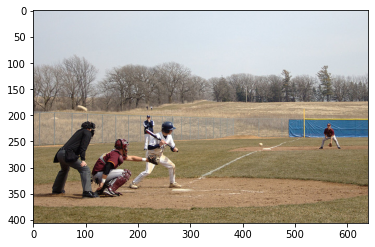

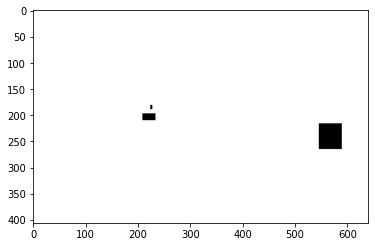

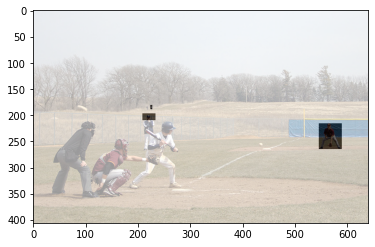

In [3]:
index=24

#image
img=cv2.imread(val_img_list[index])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

#mask
mask_miss=cv2.imread(val_mask_list[index])
mask_miss=cv2.cvtColor(mask_miss,cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

#synthesize
blend_img=cv2.addWeighted(img,0.4,mask_miss,0.6,0)
plt.imshow(blend_img)
plt.show()

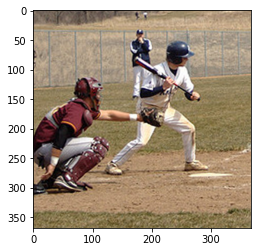

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


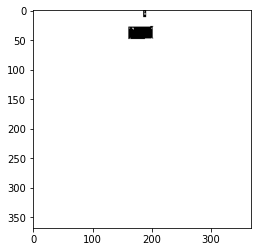

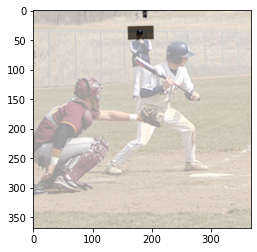

In [4]:
#データ処理のクラスとデータオーギュメンテーションのクラスをimportする
from utils.data_augumentation import Compose,get_anno,add_neck,aug_scale,aug_rotate,aug_croppad,aug_croppad,aug_flip,remove_illegal_joint,\
Normalize_Tensor,no_Normalize_Tensor

class DataTransform():
    """
    画像とマスク，アノテーションの前処理クラス
    学習時と推論時で異なる動作をする
    学習時はdata augmentationをする
    """
    
    def __init__(self):
        
        self.data_transform={
            'train':Compose([
                get_anno(), #store annotation from JSON to dict
                add_neck(), #align anno data, add neck anno data
                aug_scale(), #scaling
                aug_rotate(), #rotation
                aug_croppad(), #trimming
                aug_flip(), #flip horizontal
                remove_illegal_joint(), #remove the anno data out of img
                #Normlize_Tensor()
                no_Normalize_Tensor() #only in this chapter, no-Normalization
            ]),
            'val':Compose([
                #omit in this textbook
            ])
        }
        
    def __call__(self,phase,meta_data,img,mask_miss):
        """
        Parameters
        phase:'train'or'val' determine the mode of preprocess
        """
        meta_data,img,mask_miss=self.data_transform[phase](meta_data,img,mask_miss)
        
        return meta_data,img,mask_miss
    
#Operation check
#read the image
index=24
img=cv2.imread(val_img_list[index])
mask_miss=cv2.imread(val_mask_list[index])
meta_data=val_meta_list[index]
#preprocess
transform=DataTransform()
meta_data,img,mask_miss=transform("train",meta_data,img,mask_miss)

#display the image
img=img.numpy().transpose((1,2,0))
plt.imshow(img)
plt.show()

#display mask img
mask_miss=mask_miss.numpy().transpose((1,2,0))
plt.imshow(mask_miss)
plt.show()

#synthesize after normalize RGB values
img=Image.fromarray(np.uint8(img*255))
img=np.asarray(img.convert('RGB'))
mask_miss=Image.fromarray(np.uint8((mask_miss)))
mask_miss=np.asarray(mask_miss.convert('RGB'))
blend_img=cv2.addWeighted(img,0.4,mask_miss,0.6,0)
plt.imshow(blend_img)
plt.show()

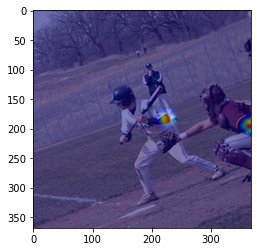

In [26]:
from utils.dataloader import get_ground_truth
from matplotlib import cm

#read image
index=24
img=cv2.imread(val_img_list[index])
mask_miss=cv2.imread(val_mask_list[index])
meta_data=val_meta_list[index]

#preprocess
meta_data,img,mask_miss=transform("train",meta_data,img,mask_miss)

img=img.numpy().transpose((1,2,0))
mask_miss=mask_miss.numpy().transpose((1,2,0))

#generate anno-data
heat_mask,heatmaps,paf_mask,pafs=get_ground_truth(meta_data,mask_miss)

#check the heatmap of left elbow
#original img
img=Image.fromarray(np.uint8(img*255))
img=np.asarray(img.convert('RGB'))

#left elbow
heat_map=heatmaps[:,:,6] #6 means left elbow
heat_map=Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map=np.asarray(heat_map.convert('RGB'))
heat_map=cv2.resize(heat_map,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_CUBIC)
# heatmap is the 1/8 size of original

#synthesize and show
blend_img=cv2.addWeighted(img,0.5,heat_map,0.5,0)
plt.imshow(blend_img)
plt.show()

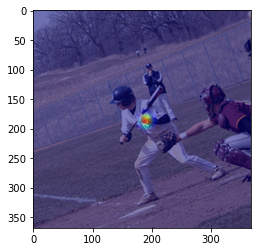

In [28]:
#left wrist
heat_map=heatmaps[:,:,7]
heat_map=Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map=np.asarray(heat_map.convert('RGB'))
heat_map=cv2.resize(heat_map,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_CUBIC)

blend_img=cv2.addWeighted(img,0.5,heat_map,0.5,0)
plt.imshow(blend_img)
plt.show()

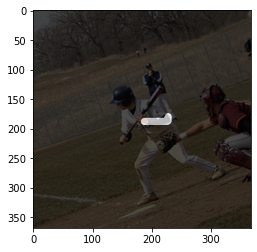

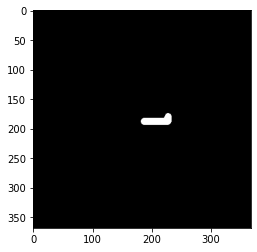

In [55]:
#check pafs to left elbow and left wrist
paf=pafs[:,:,24] #24 means a axis-x vector of PAF connecting left elbow to left wrist
paf=Image.fromarray(np.uint8((paf)*255))
paf=np.asarray(paf.convert('RGB'))
paf=cv2.resize(paf,(img.shape[1],img.shape[0]), interpolation=cv2.INTER_CUBIC)

#synthesize and show
blend_img=cv2.addWeighted(img,0.3,paf*255,0.7,0)
plt.imshow(blend_img)
plt.show()

#show only paf
plt.imshow(paf*255)
plt.show()

In [66]:
#make dataset class
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCOのCocokeypointsのdatasetを作成するクラス．pytorchのDatasetクラスを継承
    
    Attributes
    img_list : list 画像のパスを格納したリスト
    anno_list : list アノテーションへのパスを格納したリスト
    pahse : 'train' or 'test'
    transform : 前処理クラスのインスタンス
    """
    
    def __init__(self,img_list,mask_list,meta_list,phase,transform):
        super(COCOkeypointsDataset,self).__init__()
        self.img_list=img_list
        self.mask_list=mask_list
        self.meta_list=meta_list
        self.phase=phase
        self.transform=transform
        
    def __len__(self):
        #画像の枚数を返す
        return len(self.img_list)

    def __getitem__(self,index):
        img,heatmaps,heat_mask,pafs,paf_mask=self.pull_item(index)
        return img,heatmaps,heat_mask,pafs,paf_mask

    def pull_item(self,index):
        #画像のtensor形式のデータ，アノテーション，マスクを取得する

        #1. 画像読み込み
        image_file_path=self.img_list[index]
        img=cv2.imread(image_file_path) #[高さ][幅][色BGR]

        #2. マスクとアノテーション読み込み
        mask_miss=cv2.imread(self.mask_list[index])
        meta_data=self.meta_list[index]

        #3. 画像前処理
        meta_data, img, mask_miss=self.transform(self.phase,meta_data,img,mask_miss)

        #4. 正解アノテーションデータの取得
        mask_miss_numpy=mask_miss.numpy().transpose((1,2,0))
        heat_mask,heatmaps,paf_mask,pafs=get_ground_truth(meta_data,mask_miss_numpy)

        #5. マスクデータはRGBが(1,1,1)か(0,0,0)なので，次元を落とす
        #マスクデータはマスクされている場所は値が0,それ以外は1
        heat_mask=heat_mask[:,:,:,0]
        paf_mask=paf_mask[:,:,:,0]

        #6. チャネルが最後尾にあるので順番を変える
        # exp:paf_mask:torch.Size([46,46,38]) → torch.Size([38,46,46])
        paf_mask=paf_mask.permute(2,0,1)
        heat_mask=heat_mask.permute(2,0,1)
        pafs=pafs.permute(2,0,1)
        heatmaps=heatmaps.permute(2,0,1)

        return img,heatmaps,heat_mask,pafs,paf_mask

In [67]:
#Operation check
train_dataset=COCOkeypointsDataset(val_img_list,val_mask_list,val_meta_list,phase='train',transform=DataTransform())
val_dataset=COCOkeypointsDataset(val_img_list,val_mask_list,val_meta_list,phase='val',transform=DataTransform())

#data取り出し
item=train_dataset.__getitem__(0)
print(item[0].shape) #img
print(item[1].shape) #heatmaps
print(item[2].shape) #heat_mask
print(item[3].shape) #pafs
print(item[4].shape) #paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


In [68]:
#make Dataloader
batch_size=8

train_dataloader=data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

#辞書型変数にまとめる
dataloaders_dict={"train":train_dataloader,"val":val_dataloader}

#動作確認
batch_iterator=iter(dataloaders_dict["train"]) #iter に変換
item=next(batch_iterator) #1番目を取り出す
print(item[0].shape) #img
print(item[1].shape) #heatmaps
print(item[2].shape) #heat_mask
print(item[3].shape) #pafs
print(item[4].shape) #paf_mask

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])
